In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import statistics
col_width = 7.141
plt.style.use(['./figures.mplstyle'])

# Reading Data

In [4]:
minutes = [5]
devices = list(range(100, 3700, 100)) + list(range(100, 220, 20)) + list(range(200, 320, 20)) + [110, 130, 150, 190, 250, 270, 290, 810, 820, 830, 840, 850] + [510, 520, 530, 540, 550, 560, 570, 580, 590, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700]
bitlistIntervals = [10000]
moves = [False]
uniforms = [True]
broadcastTypes = ['smart', 'simple']
spacings = [2, 3, 5, 7, 10, 15]
rates = [30000]

data = {}
for minute in minutes:
    for device in devices:
        for bitlist in bitlistIntervals:
            for move in moves:
                for uniform in uniforms:
                    for broadcastType in broadcastTypes:
                        for space in spacings:
                            for rate in rates:
                                file_name = 'minutes_{minutes}_numDevices_{num_devices}_bitListInterval_{bitlist}_move_{move}_uniform_{uniform}_broadcastType_{broadcastType}_uniformSpacing_{space}_sendRate_{rate}.csv'.format(
                                    space=space, 
                                    num_devices=device, 
                                    minutes=minute, 
                                    bitlist=bitlist, 
                                    move=move, 
                                    uniform=uniform,
                                    broadcastType=broadcastType,
                                    rate=rate)
                                try:
                                    data[(minute, device, bitlist, move, uniform, broadcastType, space, rate)] = pd.read_csv('../python/processing/summaries/' + file_name)
                                except:
                                    # no data for this combo
                                    continue


# Graphing Functions

In [10]:
def get_cdf(df, col):
    sorted_data = np.sort(df[col])
    sorted_data_cdf = np.arange(len(sorted_data))/float(len(sorted_data)) * 100
    
    return sorted_data, sorted_data_cdf

def bandwidth_cdf(data, params):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel('Mb/s')
    ax.set_ylabel('% Data')
#     ax.set_title('Bandwidth CDF')ß
    
    for device in params['devices']:
        xs, ys = get_cdf(data[(params['minute'], 
                             device, 
                             params['bitlist'], 
                             params['move'], 
                             params['uniform'],
                             params['broadcastType'],
                             params['space'], 
                             params['rate'])], 
                       'MB')
        # convert to Mb/s
        xs = [x * 8 for x in xs]
        label = '{device} Devices'.format(device=device)
        ax.plot(xs, ys, label=label)

    # add vertical line at 2 Mb/s
    plt.axvline(x = 2, color = 'black', linestyle='--')
    
    ax.legend()
    
    name = 'bandwidth_minutes_{minutes}_bitListInterval_{bitlist}_move_{move}_uniform_{uniform}_broadcastType_{broadcastType}_uniformSpacing_{space}_sendRate_{rate}.pdf'.format( 
                space=params['space'],                        
                minutes=params['minute'], 
                bitlist=params['bitlist'], 
                move=params['move'], 
                uniform=params['uniform'], 
                broadcastType=params['broadcastType'],
                rate=params['rate'])
    
    plt.savefig('./Figures/bandwidths/' + name, format='pdf')
    
    plt.show()

In [1]:
def avg_device_quantile(df, q):
    num_devices = len(df['Device'].unique())
    # find qth quantile for each device
    quantiles = [total_quantile(df[df['Device'] == dev_id], q) for dev_id in range(num_devices)]
    return sum(quantiles) / num_devices

def med_device_quantile(df, q):
    num_devices = len(df['Device'].unique())
    # find qth quantile for each device
    quantiles = [total_quantile(df[df['Device'] == dev_id], q) for dev_id in range(num_devices)]
    return statistics.median(quantiles)

def total_quantile(df, q):
    return df['MB'].quantile(q)

def capacity_line(data, params, q, measure):
    bws = {}
    
    # get all bandwidths
    for space, devices in params['spacings'].items():
        for device in devices:
            df = data[(params['minute'], device, params['bitlist'], params['move'], params['uniform'], params['broadcastType'], space, params['rate'])]
            bws[(device, space)] = measure(df, q)
           
    # find capacities (largest bw < 0.25 that we see)
    capacities = {}
    for space in params['spacings']:
        capacities[space] = 0
        
    for space, devices in params['spacings'].items():
        for device in devices:
            if (capacities[space] < device) and (bws[(device, space)] <= 0.25):
                capacities[space] = device
                  
    display(capacities)
    xs, ys = zip(*capacities.items())
    
    return xs, ys

def capacities(data, params, qs, measure):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel('Spacing (ft. apart)')
    ax.set_ylabel('Number of Devices')
#     ax.set_title('Capacities')
    
    for q in qs:
        xs, ys = capacity_line(data, params, q, measure)
        print(xs, ys)
        ax.plot(xs, ys, marker='o', label='{percentile:0.0f}th percentile'.format(percentile=q*100))
    
    plt.legend()
    
    name = 'capacity_minutes_{minutes}_bitListInterval_{bitlist}_move_{move}_uniform_{uniform}_broadcastType_{broadcastType}_sendRate_{rate}.pdf'.format( 
                                minutes=params['minute'], 
                                bitlist=params['bitlist'], 
                                move=params['move'], 
                                uniform=params['uniform'], 
                                broadcastType=params['broadcastType'],
                                rate=params['rate'])
    
    plt.savefig('./Figures/capacity/' + name, bbox_inches = 'tight',
    pad_inches = 0.1, format='pdf')
    
    plt.show()
    
    return xs, ys


# Smart Broadcasting

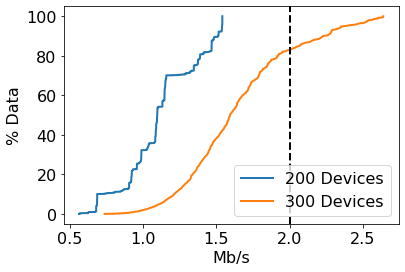

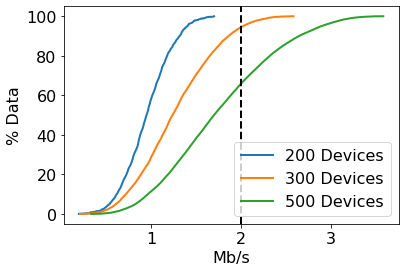

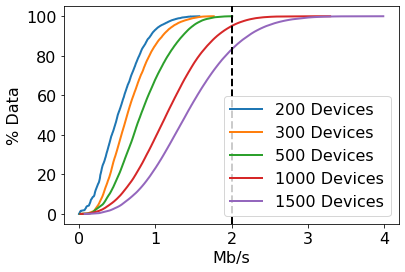

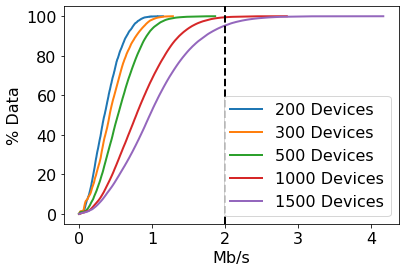

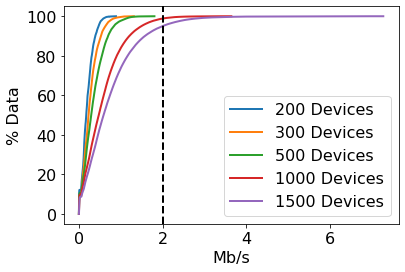

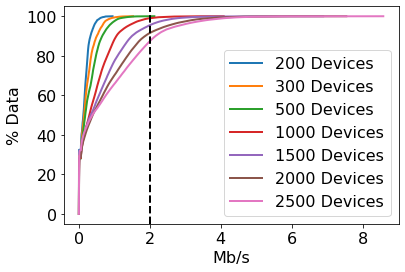

In [11]:
bandwidth_cdf(data, {'space': 2, 
                     'minute': 5, 
                     'bitlist': 10000, 
                     'move': False, 
                     'uniform': True, 
                     'broadcastType': 'smart',
                     'rate': 30000,
                     'devices': [200, 300]})

bandwidth_cdf(data, {'space': 3, 
                     'minute': 5, 
                     'bitlist': 10000, 
                     'move': False, 
                     'uniform': True, 
                     'broadcastType': 'smart',
                     'rate': 30000,
                     'devices': [200, 300, 500]})

bandwidth_cdf(data, {'space': 5, 
                     'minute': 5, 
                     'bitlist': 10000, 
                     'move': False, 
                     'uniform': True, 
                     'broadcastType': 'smart',
                     'rate': 30000,
                     'devices': [200, 300, 500, 1000, 1500]})

bandwidth_cdf(data, {'space': 7, 
                     'minute': 5, 
                     'bitlist': 10000, 
                     'move': False, 
                     'uniform': True, 
                     'broadcastType': 'smart',
                     'rate': 30000,
                     'devices': [200, 300, 500, 1000, 1500]})

bandwidth_cdf(data, {'space': 10, 
                     'minute': 5, 
                     'bitlist': 10000, 
                     'move': False, 
                     'uniform': True,
                     'broadcastType': 'smart',
                     'rate': 30000,
                     'devices': [200, 300, 500, 1000, 1500]})

bandwidth_cdf(data, {'space': 15, 
                     'minute': 5, 
                     'bitlist': 10000, 
                     'move': False, 
                     'uniform': True, 
                     'broadcastType': 'smart',
                     'rate': 30000,
                     'devices': [200, 300, 500, 1000, 1500, 2000, 2500]})

{2: 200, 3: 300, 5: 1400, 7: 2100, 10: 2700, 15: 2600}

(2, 3, 5, 7, 10, 15) (200, 300, 1400, 2100, 2700, 2600)


{2: 200, 3: 300, 5: 1300, 7: 1900, 10: 2200, 15: 2100}

(2, 3, 5, 7, 10, 15) (200, 300, 1300, 1900, 2200, 2100)


{2: 200, 3: 200, 5: 1000, 7: 1500, 10: 1500, 15: 1500}

(2, 3, 5, 7, 10, 15) (200, 200, 1000, 1500, 1500, 1500)


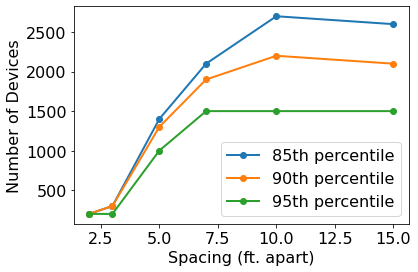

((2, 3, 5, 7, 10, 15), (200, 200, 1000, 1500, 1500, 1500))

In [20]:
space_device_mappings = {2: range(100, 1000, 100), # complete (did not step by 10s)
                         3: range(100, 1000, 100), # complete (did not step by 10s)
                         5: range(100, 1600, 100), # complete (did not step by 10s)
                         7: range(100, 2600, 100), # complete (did not step by 10s)
                         10: range(100, 3100, 100), # complete (did not step by 10s)
                         15: range(1500, 3600, 100)} # complete (did not step by 10s)

params = {'minute': 5, 
          'bitlist': 10000, 
          'move': False,
          'uniform': True,
          'broadcastType': 'smart',
          'rate': 30000,
          'spacings': space_device_mappings}


capacities(data, params, [0.85, 0.9, 0.95], total_quantile)
# capacities(data, params, [0.9, 0.95], med_device_quantile)
# capacities(data, params, [0.9, 0.95], avg_device_quantile)

burstiness is a problem. if we added queues and limited sending to 2 Mb / 10 per 100ms, how would this change things?




**Does the amount of traffic continue to increase as more messages are sent or does it level off? - need to run for > 5 min** - time series of total network volume

show that traffic is less at the start of simulation than at the end

# Simple Broadcasting

{2: 110, 3: 110, 5: 180, 7: 290, 10: 690, 15: 1800}

(2, 3, 5, 7, 10, 15) (110, 110, 180, 290, 690, 1800)


{2: 110, 3: 100, 5: 150, 7: 270, 10: 670, 15: 1700}

(2, 3, 5, 7, 10, 15) (110, 100, 150, 270, 670, 1700)


{2: 100, 3: 100, 5: 140, 7: 240, 10: 620, 15: 1700}

(2, 3, 5, 7, 10, 15) (100, 100, 140, 240, 620, 1700)


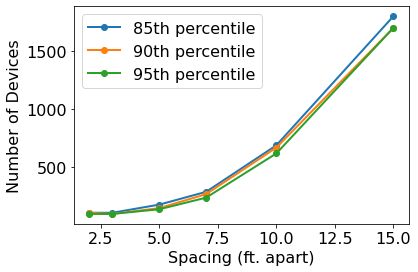

((2, 3, 5, 7, 10, 15), (100, 100, 140, 240, 620, 1700))

In [21]:
space_device_mappings = {2: [100, 110], # complete
                         3: [100, 110], # complete
                         5: [120, 130, 140, 150, 160, 180], # complete
                         7: [240, 250, 260, 270, 280, 290], # complete
                         10: [100, 200, 300, 400, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700], # complete
                         15: [800, 810, 820, 830, 840, 850, 900, 1000, 1500, 1600, 1700, 1800, 1900]} # complete (did not step by 10s)
params = {'minute': 5, 
          'bitlist': 10000, 
          'move': False,
          'uniform': True,
          'broadcastType': 'simple',
          'rate': 30000,
          'spacings': space_device_mappings}


capacities(data, params, [0.85, 0.9, 0.95], total_quantile)